# Calculate Signal-to-Noise (SNR) values to evaluate the privacy leakage of Power/EM trace in Side-Channel Attacks

step1: For the input npz file, which includes [power_trace, plain_text,key] attributes, we first extract the power/EM trace as X, and calculating the correspoding labels as y for these traces.

step2: Given X and y, we calculate the SNR values and save the results

In [1]:
import numpy as np
%load_ext autotime

### Pre-processing data
Extract power/EM trace as X, corresponding label as Y

In [2]:
## paramaters
data_params = {
    "target_byte": 0,  # byte on which attack is to be performed (at this point, 0 for all unmasked XMEGA)
    "start_idx": 1800, # the start index of attacking window
    "end_idx": 2800, # the end index of attacking window
    "input_path": './our_data/unmasked/device01/PC1_CB1_TDX1_K0_U_20k_0317.npz', # data path for pre-processing
    "figure_output_path": "./results/PC1_CB1_TDX1_K0_U_20k_0317_snr.png",
    "result_output_path": "./results/PC1_CB1_TDX1_K0_U_20k_0317_snr.csv"
}

time: 164 µs


##### Functions for AES operation, getting information of input data, and generating corresponding labels

In [3]:
## AES operations
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,  # 0
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,  # 1
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,  # 2
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,  # 3
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,  # 4
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,  # 5
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,  # 6
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,  # 7
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,  # 8
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,  # 9
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,  # a
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,  # b
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,  # c
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,  # d
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,  # e
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16  # f
]


def aes_internal(inp_data_byte, key_byte):
    """
    This function performs XOR operation between the input byte and key byte which is used as label.
    """
    inp_data_byte = inp_data_byte.astype(np.uint8)
    key_byte = key_byte.astype(np.int64)
    return sbox[inp_data_byte ^ key_byte]


## get information of raw data
def data_info(data):
    """
    This function prints the information of the dataset.
    """
    # loading the dataset
    power_traces, plain_text, key = data['power_trace'], data['plain_text'], data['key']
    
    print(f'index of data {data.files}')
    print('shape of the traces: ', power_traces.shape)
    print('shape of the plaintext : ', plain_text.shape)
    print('Ground Truth for the key : ', key)
    

## generate labels
def gen_features_and_labels_256_2(data, key_byte_value, input_target_byte, start_index, end_index):
    """
    This function generates features and labels for the dataset.
    """

    # loading the dataset
    if 'key' in data.files:
        power_traces, plain_text, key = data['power_trace'], data['plain_text'], data['key']
    else:
        power_traces, plain_text = data['power_trace'], data['plain_text']

    print('generating features and labels for the key byte value: ', key_byte_value)

    # key byte is the value between 0 and 15 (index)
    labels = []
    for i in range(plain_text.shape[0]):
        text_i = plain_text[i]
        label = aes_internal(text_i[input_target_byte], key_byte_value) #key[i][input_key_byte]
        labels.append(label)

    labels = np.array(labels)
    if not isinstance(power_traces, np.ndarray):
        power_traces = np.array(power_traces)
    power_traces = power_traces[:, start_index:end_index]

    return power_traces, labels

time: 53 ms


##### Load input data and extract the power/EM trace and get labels

In [4]:
## load data and print info
raw_data = np.load(data_params['input_path'])
data_info(raw_data)

## get labels 
key_byte_value=raw_data['key'][data_params['target_byte']]
print(f"real key: {key_byte_value}")
power_traces_processed,labels = gen_features_and_labels_256_2(raw_data, 
                                                              key_byte_value,
                                                              data_params['target_byte'],
                                                              data_params['start_idx'],
                                                              data_params['end_idx'])

## print processed data info
print(f"processed traces shape is {power_traces_processed.shape}, data type is {type(power_traces_processed)}")
print(f"generated labels shape is {labels.shape}, number of class {max(labels+1)}, data type is {type(labels)}")

X = power_traces_processed
y = labels

index of data ['power_trace', 'plain_text', 'key']
shape of the traces:  (40000, 5000)
shape of the plaintext :  (40000, 16)
Ground Truth for the key :  [ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
real key: 43
generating features and labels for the key byte value:  43
processed traces shape is (40000, 1000), data type is <class 'numpy.ndarray'>
generated labels shape is (40000,), number of class 256, data type is <class 'numpy.ndarray'>
time: 2.48 s


### Calculate Signal-to-Noise (SNR) 
calculate SNR over the extracted power/EM trace data and the corresponding labels

In [5]:
def signaltonoise(X,y):
    """
    calculate singal to noise (SNR) based on the Equation 5 from paper "https://eprint.iacr.org/2017/608.pdf" 
    to evaluate the privacy leakage 
    
    X: ndarray, data (e.g., EM/power trace data)
    y: list or array, corresponding label
    
    return: a vector that consists snr value across different
    
    """
    snr = []
    for c in range(X.shape[-1]):
        e_list, var_list = [],[] # expectation and variance for each column
        for j in set(y):
            temp = []
            index = np.where(y == j)
            for r in index:
                temp.append(X[r,c])
            e_list.append(np.array(temp).mean())
            var_list.append(np.var(temp))

        var_e = np.var(e_list)
        e_var = np.array(var_list).mean()

        snr.append(var_e / e_var)
    
    return snr

time: 275 µs


In [6]:
## get snr
import pandas as pd

snr = signaltonoise(X,y)

pd.DataFrame(snr).to_csv(data_params['result_output_path'],index=False)
print(f"results save in {data_params['result_output_path']}")

results save in ./results/PC1_CB1_TDX1_K0_U_20k_0317_snr.csv
time: 14.1 s


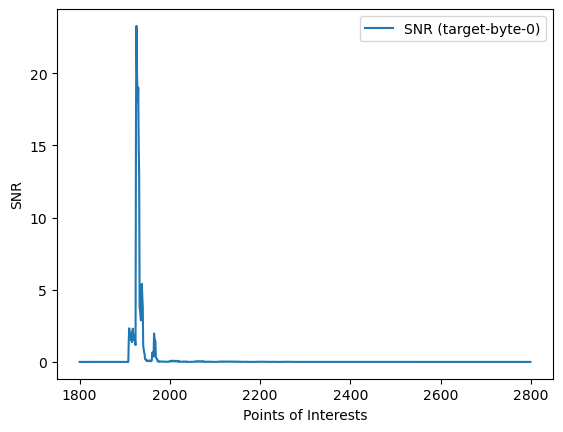

result save in ./results/PC1_CB1_TDX1_K0_U_20k_0317_snr.png
time: 233 ms


In [7]:
## plot snr
import matplotlib.pyplot as plt 

f_name = "target-byte-" + str(data_params["target_byte"])
x_ticks = list(range(data_params['start_idx'], data_params['end_idx']))

plt.plot(x_ticks,snr,label="SNR ({})".format(f_name))
plt.xlabel('Points of Interests')
plt.ylabel('SNR')
plt.legend()

plt.savefig(data_params['figure_output_path'])
plt.show()
print(f"result save in {data_params['figure_output_path']}")